# Fake news detection Explained


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [29]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [30]:
fake.shape

(23481, 4)

In [31]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [32]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [33]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
#data = shuffle(data)
print(data)
#data=data.iloc[:5]
data.shape
print(data)


#data = data.reset_index(drop=True)

                                                   title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       New

In [34]:
# Shuffle the data

from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [35]:
# Check the data
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


,title,text,subject,date,target
0,LIBERAL HEADS EXPLODE When PIERS MORGAN Points...,Watch the video and you be the judge. Was Pier...,politics,"Jun 6, 2016",fake
1,House rejects bill requiring carriers to share...,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,"May 24, 2016",true
2,"Trump says pharma 'getting away with murder,' ...",NEW YORK (Reuters) - U.S. President-elect Dona...,politicsNews,"January 11, 2017",true
3,Sanders supporters banned from Tinder after ca...,(Reuters) - Stumping for Democratic presidenti...,politicsNews,"February 5, 2016",true
4,Trump Jr. emails suggest he welcomed Russian h...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"July 11, 2017",true


In [36]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,LIBERAL HEADS EXPLODE When PIERS MORGAN Points...,Watch the video and you be the judge. Was Pier...,politics,fake
1,House rejects bill requiring carriers to share...,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,true
2,"Trump says pharma 'getting away with murder,' ...",NEW YORK (Reuters) - U.S. President-elect Dona...,politicsNews,true
3,Sanders supporters banned from Tinder after ca...,(Reuters) - Stumping for Democratic presidenti...,politicsNews,true
4,Trump Jr. emails suggest he welcomed Russian h...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,true


In [37]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Watch the video and you be the judge. Was Pier...,politics,fake
1,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,true
2,NEW YORK (Reuters) - U.S. President-elect Dona...,politicsNews,true
3,(Reuters) - Stumping for Democratic presidenti...,politicsNews,true
4,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,true


In [38]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,watch the video and you be the judge. was pier...,politics,fake
1,washington (reuters) - the u.s. house of repre...,politicsNews,true
2,new york (reuters) - u.s. president-elect dona...,politicsNews,true
3,(reuters) - stumping for democratic presidenti...,politicsNews,true
4,washington (reuters) - president donald trump’...,politicsNews,true


In [39]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [40]:
# Check
data.head()

,text,subject,target
0,watch the video and you be the judge was piers...,politics,fake
1,washington reuters the us house of representa...,politicsNews,true
2,new york reuters us presidentelect donald tru...,politicsNews,true
3,reuters stumping for democratic presidential ...,politicsNews,true
4,washington reuters president donald trump’s e...,politicsNews,true


In [41]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /Users/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
data.head()

,text,subject,target
0,watch video judge piers morgan correct linepie...,politics,fake
1,washington reuters us house representatives vo...,politicsNews,true
2,new york reuters us presidentelect donald trum...,politicsNews,true
3,reuters stumping democratic presidential candi...,politicsNews,true
4,washington reuters president donald trump’s el...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


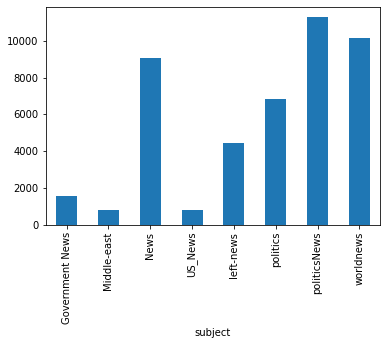

In [43]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


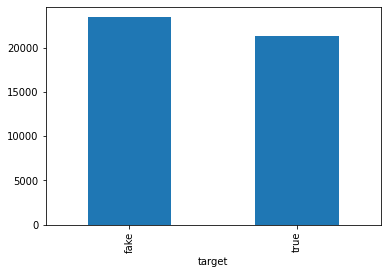

In [44]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

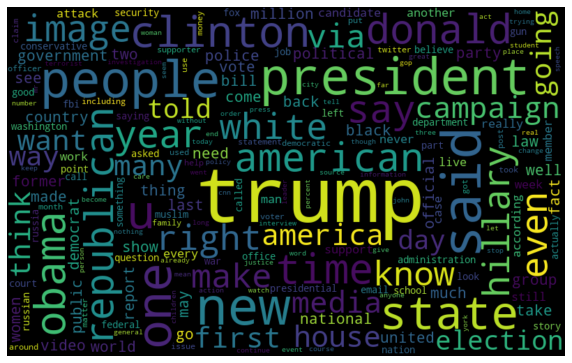

In [45]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

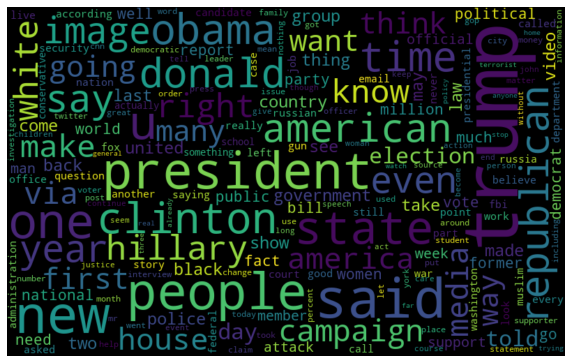

In [46]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

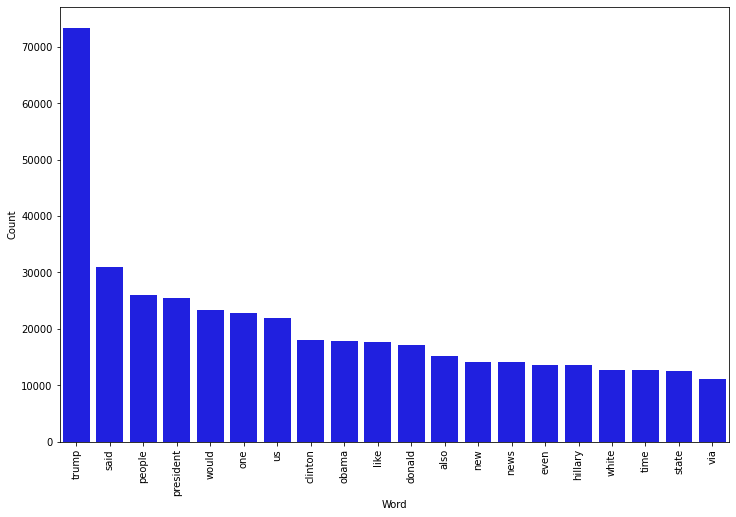

In [48]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

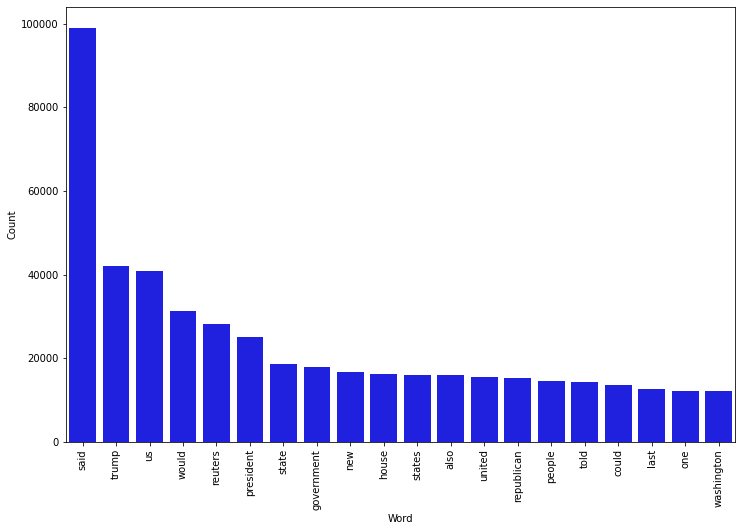

In [49]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [50]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [59]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)
#print(type(data))
print(type(X_test))
X_test=np.array(X_test)
print(type(X_test))
#print(y_test)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


# **Naive Bayes**




In [52]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.3%


Confusion matrix, without normalization


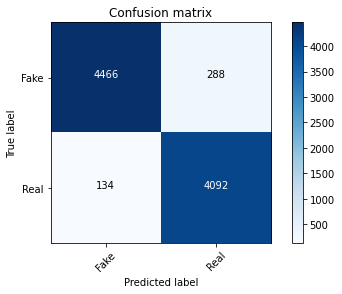

In [53]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [56]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

'''
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

'''
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, shuffle=False)
print('xtrain shape = ',X_train.shape)
print('ytrain shape = ',y_train.shape)
print('x_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)

X_total=pd.concat([X_train,X_test])
print('X_total shape = ',X_total.shape)
ltotal=len(X_total)
#print(X_total)
'''
vectorizer = CountVectorizer()
v = vectorizer.fit_transform(X_total)
features=vectorizer.get_feature_names_out()
tfr=TfidfTransformer()
tf=tfr.fit_transform(v)
'''
vectorizer=TfidfVectorizer(lowercase=False)
v = vectorizer.fit_transform(X_total)
features=vectorizer.get_feature_names_out()
tf=v


print('tf total shape = ',tf.shape)
print('len(tf) = ', tf.shape[0])
ltrain=X_train.shape[0]
print('ltrain = ',ltrain)
tftrain=tf[0:ltrain][:]
tftest=tf[ltrain:][:]

print('tftrain shape = ', tftrain.shape)
print('tftest shape = ',tftest.shape)



mo=LogisticRegression()
mo.fit(tftrain,y_train)
m=mo.predict(tftest)
print(m)
prediction = mo.predict(tftest)
print('prediction shape = ',prediction.shape)

print('prediction : ',prediction)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)




xtrain shape =  (35918,)
ytrain shape =  (35918,)
x_test shape =  (8980,)
y_test shape =  (8980,)
X_total shape =  (44898,)
tf total shape =  (44898, 225972)
len(tf) =  44898
ltrain =  35918
tftrain shape =  (35918, 225972)
tftest shape =  (8980, 225972)
['true' 'fake' 'true' ... 'true' 'fake' 'true']
prediction shape =  (8980,)
prediction :  ['true' 'fake' 'true' ... 'true' 'fake' 'true']
accuracy: 98.84%


In [80]:
from lime import lime_tabular
#print(X_test)
l=len(X_test)
print(l)
i = np.random.randint(1, l)
j=i+ltrain
#print('j = ',j)
p=mo.predict(tftest)


#print('xtrain type = ',type(X_train[12]))
#print(X_test[j])
#print(np.array(X_test[i]).shape)

h="hello world"
print(type(X_test[12]))
#vectorizer.transform(h)

def predict_fn(news):
    
    vk=vectorizer.transform(news)
    r=mo.predict(vk)
    return(r)
print(type(X_train[12]))
print(predict_fn((X_test[i][:])))



"""
print(predict_fn(X_train[12]))

pi=p[i]
#print('p = ',p)
#print('i = ',i)
#print('y_test = ',y_test)
#print("Prediction : ", pi)

#print("Actual : ", y_test[j])

explainer = lime_tabular.LimeTabularExplainer(tf, mode="regression", feature_names= features)
explainer
#print(X_test)
#print(np.array(X_test[j]))
#print(X_test)
#print('number features = ',)
tfs=tf.shape[1]
#print(tftest[i])


explanation = explainer.explain_instance(h, predict_fn, num_features=tfs)

explanation
explanation.show_in_notebook()
"""

8980
<class 'str'>
<class 'str'>


ValueError: Iterable over raw text documents expected, string object received.

Confusion matrix, without normalization


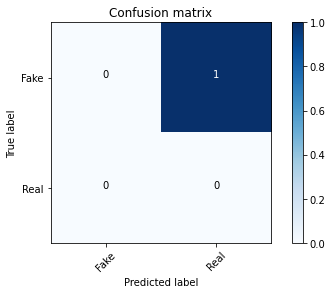

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 0.0%


Confusion matrix, without normalization


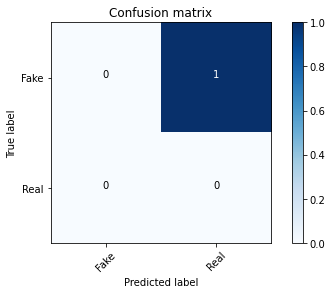

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 0.0%


Confusion matrix, without normalization


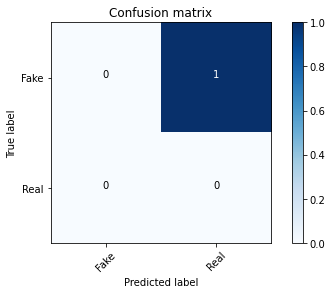

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



Confusion matrix, without normalization


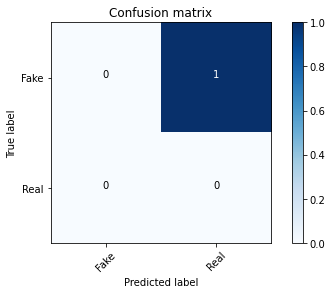

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x7f7e96b0e670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

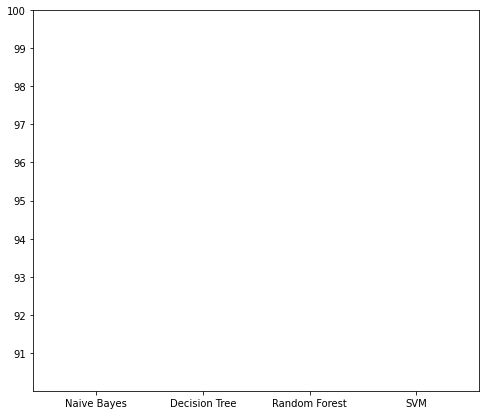

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [ ]:
the end.....

SyntaxError: invalid syntax (2237372829.py, line 1)